<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#5642C5;
           font-size:200%;
           font-family:Arial;letter-spacing:0.5px">

<p width = 20%, style="padding: 10px;
              color:white;">
Natural Language Processing: Classification
              
</p>
</div>

DS-NTL-010824<p>Phase 4</p>
<br>
<br>

<div align = "right">
<img src="Images/flatiron-school-logo.png" align = "right" width="200"/>
</div>
    
    

In [1]:
# integrating our preprocessing into a pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
import pandas as pd
import numpy as np
from nltk import WordNetLemmatizer # lemmatizer using WordNet
from nltk.corpus import wordnet # imports WordNet
from nltk import pos_tag # nltk's native part of speech tagging
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from sklearn.metrics import classification_report
#from sklearn.metrics import plot_confusion_matrix #depreciated
from sklearn.metrics import ConfusionMatrixDisplay,RocCurveDisplay,roc_auc_score
#from sklearn.metrics import plot_roc_curve


Build a very simple stateless transformer:
- Cleans/preprocesses text

In [2]:
class TextPreprocessor(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        
        #define attributes to store if text preprocessing requires fitting from data
        pass
    
    def fit(self, data, y = 0):
        # this is where you would fit things like corpus specific stopwords
        # fit probable bigrams with bigram model in here
        
        # save as parameters of Text preprocessor
        
        return self
    
    def transform(self, data, y = 0):
        fully_normalized_corpus = data.apply(self.process_doc)
        
        return fully_normalized_corpus
        
    
    def process_doc(self, doc):

        #initialize lemmatizer
        wnl = WordNetLemmatizer()
        stop_words = stopwords.words('english')
        
        # helper function to change nltk's part of speech tagging to a wordnet format.
        def pos_tagger(nltk_tag):
            if nltk_tag.startswith('J'):
                return wordnet.ADJ
            elif nltk_tag.startswith('V'):
                return wordnet.VERB
            elif nltk_tag.startswith('N'):
                return wordnet.NOUN
            elif nltk_tag.startswith('R'):
                return wordnet.ADV
            else:         
                return None


        # remove stop words and punctuations, then lower case
        doc_norm = [tok.lower() for tok in word_tokenize(doc) if ((tok.isalpha()) & (tok not in stop_words)) ]

        #  POS detection on the result will be important in telling Wordnet's lemmatizer how to lemmatize

        # creates list of tuples with tokens and POS tags in wordnet format
        wordnet_tagged = list(map(lambda x: (x[0], pos_tagger(x[1])), pos_tag(doc_norm))) 
        doc_norm = [wnl.lemmatize(token, pos) for token, pos in wordnet_tagged if pos is not None]

        return " ".join(doc_norm)

In [3]:
data = pd.read_csv('Data/satire_nosatire.csv')
X = data['body']
y = data['target']

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

proc = TextPreprocessor()

transformed_train = proc.fit_transform(X_train) 


In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [6]:
prc_steps = [('countvec', CountVectorizer(min_df = 0.05, max_df = 0.95))]
preprocess_pipeline = Pipeline(prc_steps)

In [7]:
X_tr_proc = preprocess_pipeline.fit_transform(transformed_train)

In [8]:
X_tr_proc

<700x602 sparse matrix of type '<class 'numpy.int64'>'
	with 45177 stored elements in Compressed Sparse Row format>

In [12]:
feat_names = preprocess_pipeline[
    'countvec'].get_feature_names()

pd.DataFrame(X_tr_proc.toarray(), columns = feat_names)

,able,accord,account,accuse,act,action,activist,actually,add,additional,...,word,work,worker,world,worry,write,year,yes,yet,young
0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,1,0,...,0,1,0,0,0,0,1,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,4,0,0,1,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,2,0,0,0,1,0,0,0,0
4,0,0,0,1,0,0,2,0,0,0,...,0,0,3,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
695,0,0,0,0,0,0,0,0,0,0,...,1,2,0,0,1,0,0,0,1,0
696,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,1,0,0
697,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
698,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,3,0,0,0


#### Building a document classifier model

**Naive Bayes with Multinomial Distribution Likelihood**

- Can be effective for modeling document-term frequency matrix to target class relationships
-  "naive" assumption that the features (term frequencies) are conditionally independent given the class label. 

Bayes theorem:

$$ P(c|\textbf{x}) = \frac{P(\textbf{x}|c)P(c)}{P(\textbf{x})} $$

- Likelihood; $P(\textbf{x}|c)$
- Prior: $P(c)$
- Posterior: $P(c|\textbf{x}) $

Bayes classifier:
    
$$f(\textbf{x}) = \hat{c} = \underset{c \in C}{\arg\max} P(\textbf{x}|c)P(c)$$

#### Prior
- simply the target fraction

In [13]:
class_priors = y_train.value_counts()/y_train.shape[0]
class_priors

1    0.5
0    0.5
Name: target, dtype: float64

#### The likelihood function

**First step: word count distribution**:

- Multinomial distribution (generalization of 
binomial distribution)

For document with $m$ tokens:
- dictionary of corpus has $d$ unique tokens.
- $\textbf{x} = (x_1,...., x_d)$ vector of token counts for document.



An analogy: $d = 6$ M&M colors

Picking $ m $ M&Ms.

<img src = "Images/picking_candy.jpg" >
    
Follow multinomial distribution.


<a href = "https://www.mashed.com/679227/the-rarest-mm-color-may-surprise-you/#:~:text=Brown%20is%20currently%20the%20rarest%20color%20of%20M%26M's&text=As%20such%2C%20they%20used%20their,their%20findings%20were%20quite%20surprising."> Some interesting facts about M&Ms. </a>

$$ P(\textbf{x}|\theta) = \frac{m!}{x_1!x_2!...x_d!} \theta_{1}^{x_1}\theta_{2}^{x_2}...\theta_{d}^{x_d} $$
Parameters of distribution:
- $\theta_i$: probability of picking $i^{th}$ token  in dictionary from bag of words

**To be estimated from the data**

Words draws/order are **independent** of each other: the **naive** assumption.

<img src = "Images/scrabble.webp" />

#### Second Step: class conditional word count

$$ P(\textbf{x}|c) = \frac{m!}{x_1!x_2!...x_d!} [\theta_c]_{1}^{x_1}[\theta_c]_{2}^{x_2}...[\theta_c]_{d}^{x_d} $$
- $[\theta_c]$ is **class-dependent** set of probability parameters.

Need to fit probability parameters from data.

**Fitting probability parameters for each class**

- Very straightforward.
- Probability of drawing token $i$ if document class $c$

$$ [\hat{\theta}_c]_i = \frac{N_{ci}}{N_c}$$

- Count token $i$ occurence across all documents of class $c$
- Divide by total token count for all documents of class $c$

#### Getting the fit parameters with code

In [14]:
bow_mat = pd.DataFrame(X_tr_proc.toarray(), columns = feat_names)
bow_mat['target'] = y_train
bow_mat

,able,accord,account,accuse,act,action,activist,actually,add,additional,...,word,work,worker,world,worry,write,year,yes,yet,young
0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,1,0,...,0,1,0,0,0,0,1,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,4,0,0,1,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,2,0,0,0,1,0,0,0,0
4,0,0,0,1,0,0,2,0,0,0,...,0,0,3,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
695,0,0,0,0,0,0,0,0,0,0,...,1,2,0,0,1,0,0,0,1,0
696,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,1,0,0
697,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
698,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,3,0,0,0


In [15]:
class1_bow_mat = bow_mat[bow_mat['target'] == 1].drop(columns = ['target'])

# class 1 token probabilities:
N_tok_1 = class1_bow_mat.sum(axis = 0) # token occurence
N_1 =  class1_bow_mat.values.sum() # number of tokens

# get probabilities for each token: class 1
proba_c1 = N_tok_1/N_1

proba_c1.sort_values(ascending = False)[0:10]

say       0.033241
people    0.009515
year      0.009304
see       0.007588
take      0.007527
state     0.007437
eu        0.007256
go        0.006865
get       0.006714
make      0.006534
dtype: float64

In [16]:
class0_bow_mat = bow_mat[bow_mat['target'] == 0].drop(columns = ['target'])

# class 0 token probabilities:
N_tok_0 = class0_bow_mat.sum(axis = 0)
N_0 =  class0_bow_mat.values.sum() 

# get probabilities for each token: class 0
proba_c0 = N_tok_0/N_0

proba_c0.sort_values(ascending = False)[0:10]

say           0.032553
year          0.012070
people        0.011485
trump         0.010388
state         0.008266
government    0.007901
president     0.007315
get           0.006876
time          0.006803
take          0.006730
dtype: float64

#### Computing likelihood

In [17]:
from scipy.stats import multinomial

Take document:

In [18]:
X_train.iloc[50]

'Speaking from his bunker deep in the Treasury, the Remoaner, Lord Haw Haw Hammond broadcasted that he is delighted with the punishment budget he will unleash across the whole of Britain. The Voice of the Axis “In line with my Remainer policies, and the vile impudent populace who voted for Brexit, I wish to punish you deeply by raising taxes and taking away funding from key areas of the economy. It’s because you people <spitting> still do not capitulate to our masters in Brussels. I was planted into this high position by our Remainer Prime Minister, Theresa May, and the Remainer led Cabinet. I am justified in punishing you British swine for your indiscretions. Haw, haw, haw, haw!” Many Brits who are already struggling under the regime of a Remainer-led Cabinet were naturally defiant about Lord Haw Haw Hammond’s punishment budget. “They can punish us as much as they want. They can have as many referendums as they want, we will not surrender, we will fight from the hill tops, we will fig

In [19]:
# bow vector for document
bow_mat_feat = bow_mat.drop(columns = ['target'])
word_vec = bow_mat_feat.iloc[50]
word_vec

able       0
accord     0
account    0
accuse     0
act        0
          ..
write      0
year       0
yes        0
yet        0
young      0
Name: 50, Length: 601, dtype: int64

In [20]:
y_train.iloc[50]

1

In [21]:
article_length = word_vec.sum()
article_length

49

In [22]:
class1_likelihood = multinomial.pmf(x = word_vec.values, n = article_length, p =  proba_c1.values)
class0_likelihood = multinomial.pmf(x = word_vec.values, n = article_length, p =  proba_c0.values)

Now use Bayes theorem for classifier:

$$f(\textbf{x}) = \hat{c} = \underset{c \in C}{\arg\max} P(\textbf{x}|c)P(c)$$


with multinomial likelihood

$$ P(\textbf{x}|c) = \frac{m!}{x_1!x_2!...x_d!} [\hat{\theta}_c]_{1}^{x_1}[\hat{\theta}_c]_{2}^{x_2}...[\hat{\theta}_c]_{d}^{x_d} $$

and fitted parameters

$$ [\hat{\theta}_c]_i = \frac{N_{ci}}{N_c}$$

Evaluate class for this document:

$$f(\textbf{x}) = \hat{c} = \underset{c \in C}{\arg\max} P(\textbf{x}|c)P(c)$$

In [23]:
class1_likelihood*class_priors[1]

1.6065138126391637e-74

In [24]:
class0_likelihood*class_priors[0]

6.402394829433637e-79

Given scale of probabilities:
- Comparison done on log scale

$$f(\textbf{x}) = \hat{c} = \underset{c \in C}{\arg\max} \Big[ \log\Big(P(\textbf{x}|c)P(c)\Big) \Big]$$

In [25]:
np.log10(class1_likelihood*class_priors[1])

-73.7941155360775

In [26]:
np.log10(class0_likelihood*class_priors[0])

-78.19365754684966

#### Laplace Smoothing: practical correction

- A fudge count $\alpha$ added to token count in each class.
- Avoids issues with having zero counts $N_c$ and $N_{ci}$ in training set.

$$ [\hat{\theta}_c]_i = \frac{N_{ci} + \alpha}{N_c + \alpha d}$$

- Typically $\alpha = 1$. Can tune this.

- $d$ is the dimensionality of our vocabulary
- $N_{ci}$ the count of token $i$ in class $c$
- $N_{c}$ the count of all tokens in class $c$

Append Multinomial Naive Bayes Classifier to pipeline.

In [27]:
from sklearn.naive_bayes import MultinomialNB

In [28]:
from copy import deepcopy
mod_pipe = deepcopy(preprocess_pipeline)
mod_pipe.steps.append(('multinb', MultinomialNB()))
mod_pipe.steps

[('countvec', CountVectorizer(max_df=0.95, min_df=0.05)),
 ('multinb', MultinomialNB())]

In [29]:
mod_pipe.fit(transformed_train, y_train)

Pipeline(steps=[('countvec', CountVectorizer(max_df=0.95, min_df=0.05)),
                ('multinb', MultinomialNB())])

In [30]:
transformed_test = proc.transform(X_test)

y_pred = mod_pipe.predict(transformed_test) # automatically applies vectorizer and predicts on test

In [31]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.97      0.96       150
           1       0.97      0.95      0.96       150

    accuracy                           0.96       300
   macro avg       0.96      0.96      0.96       300
weighted avg       0.96      0.96      0.96       300



In [32]:
roc_auc_score(y_test, y_pred)

0.9633333333333334

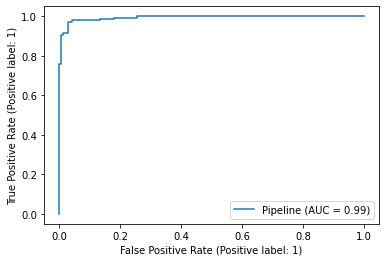

In [35]:
#plot_roc_curve(mod_pipe, transformed_test, y_test)
#RocCurveDisplay.from_estimator
from sklearn.metrics import plot_roc_curve
plot_roc_curve(mod_pipe, transformed_test, y_test);

In [45]:
#plot_confusion_matrix(mod_pipe, transformed_test, y_test);
from sklearn.metrics import confusion_matrix
#ConfusionMatrixDisplay.from_estimator
ConfusionMatrixDisplay(mod_pipe, transformed_test, y_test);


- with proper text preprocessing steps
- Naive Bayes can perform really well on simple binary classification tasks.

#### Using TF-IDF

TFIDF does not necessarily perform better than CV:
- It is just a tool in our toolbelt often worth trying out.

In [46]:
from copy import deepcopy
tfidfmod_pipe = deepcopy(mod_pipe)
tfidfmod_pipe.steps[0] = ('tfidf', TfidfVectorizer(min_df=0.05, max_df=0.95)) # cuts words too rare/too frequent
tfidfmod_pipe.steps

[('tfidf', TfidfVectorizer(max_df=0.95, min_df=0.05)),
 ('multinb', MultinomialNB())]

In [47]:
tfidfmod_pipe.fit(transformed_train, y_train)
ypred_tfidf = tfidfmod_pipe.predict(transformed_test)

In [48]:
roc_auc_score(y_test, ypred_tfidf)

0.9566666666666667

In [49]:
#plot_confusion_matrix(tfidfmod_pipe, transformed_test, y_test);
ConfusionMatrixDisplay.from_estimator(tfidfmod_pipe, transformed_test, y_test);

AttributeError: type object 'ConfusionMatrixDisplay' has no attribute 'from_estimator'

#### With class imbalance

- Modification to Multinomial Naive Bayes: Complement Naive Bayes
- deals with data skew.

In [50]:
from sklearn.naive_bayes import ComplementNB

Pretty much same fitting/hyperparameters.

In [51]:
from copy import deepcopy
mod_comp_pipe = deepcopy(preprocess_pipeline)
mod_comp_pipe.steps.append(('compnb', ComplementNB()))
mod_comp_pipe.steps

[('countvec', CountVectorizer(max_df=0.95, min_df=0.05)),
 ('compnb', ComplementNB())]

In [52]:
mod_comp_pipe.fit(transformed_train, y_train)



Pipeline(steps=[('countvec', CountVectorizer(max_df=0.95, min_df=0.05)),
                ('compnb', ComplementNB())])

In [53]:
transformed_test = proc.transform(X_test) #preprocess
y_pred_comp = mod_comp_pipe.predict(transformed_test) #count vectorizer and ComplementNB

In [54]:
print(classification_report(y_pred_comp, y_test))

              precision    recall  f1-score   support

           0       0.97      0.95      0.96       153
           1       0.95      0.97      0.96       147

    accuracy                           0.96       300
   macro avg       0.96      0.96      0.96       300
weighted avg       0.96      0.96      0.96       300



In [56]:
#plot_confusion_matrix(mod_comp_pipe, transformed_test, y_test);
ConfusionMatrixDisplay.from_estimator(mod_comp_pipe, transformed_test, y_test);

AttributeError: type object 'ConfusionMatrixDisplay' has no attribute 'from_estimator'

Comparable performance on this balanced dataset. Will perform *much* better on imbalanced dataset than MultinomialNB